In [1]:
# Importando as Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam
import warnings
warnings.filterwarnings('ignore')

# Importando o DataFrame e Filtrando a Liga do Brasil
df = pd.read_excel("https://github.com/futpythontrader/YouTube/blob/main/x_FutPythonTrader_Base_de_Dados_Temporada_Atual_x.xlsx?raw=true")
df = df[['League','Home','Away','HT_Goals_H','HT_Goals_A','FT_Goals_H','FT_Goals_A']]
df = df[df.League == "Brazil Serie A"]

# Ajustando o Índice
df.reset_index(inplace=True, drop=True)
df.index = df.index.set_names(['Nº'])
df = df.rename(index=lambda x: x + 1)

# Apresentando o Cabeçalho do DataFrame
df.head()

,League,Home,Away,HT_Goals_H,HT_Goals_A,FT_Goals_H,FT_Goals_A
Nº,,,,,,,
1,Brazil Serie A,Fluminense,Santos,0,0,0,0
2,Brazil Serie A,Atlético GO,Flamengo,0,0,1,1
3,Brazil Serie A,Palmeiras,Ceará,1,2,2,3
4,Brazil Serie A,Coritiba,Goiás,1,0,3,0
5,Brazil Serie A,Atlético Mineiro,Internacional,1,0,2,0



$$
P\left( x \right) = \frac{e^{-\lambda} \lambda ^x }{x!}, \lambda>0
$$

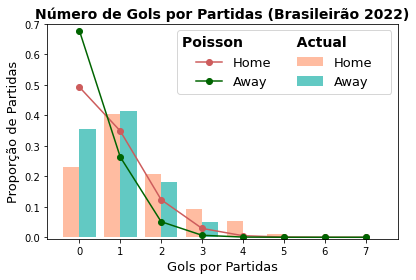

In [2]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, df.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(df[['FT_Goals_H', 'FT_Goals_A']].values, range(9), 
#         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])
         alpha=0.7, label=['Home', 'Away'],density=True, stacked=False, color=["#FFA07A", "#20B2AA"])



# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Gols por Partidas",size=13)
plt.ylabel("Proporção de Partidas",size=13)
plt.title("Número de Gols por Partidas (Brasileirão 2022)",size=14,fontweight='bold')
plt.ylim([-0.005, 0.7])
plt.tight_layout()
plt.show()

In [3]:
# probability of draw between home and away team
skellam.pmf(0.0,  df.mean()[0],  df.mean()[1])

0.43252618420230987

In [4]:
# probability of home team winning by one goal
skellam.pmf(1,  df.mean()[0],  df.mean()[1])

0.27050726823437793

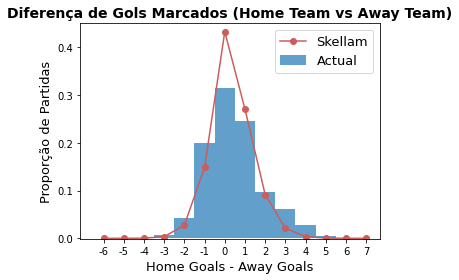

In [5]:
skellam_pred = [skellam.pmf(i,  df.mean()[0],  df.mean()[1]) for i in range(-6,8)]

plt.hist(df[['FT_Goals_H']].values - df[['FT_Goals_A']].values, range(-6,8), 
         alpha=0.7, label='Actual',density=True, stacked=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proporção de Partidas",size=13)
plt.title("Diferença de Gols Marcados (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.001, 0.45])
plt.tight_layout()
plt.show()

In [6]:
df_halves = df
df_halves = df_halves[['FT_Goals_H', 'FT_Goals_A', 'HT_Goals_H', 'HT_Goals_A']]
df_halves['FHgoals'] = df_halves['HT_Goals_H'] + df_halves['HT_Goals_A']
df_halves['SHgoals'] = df_halves['FT_Goals_H'] + df_halves['FT_Goals_A'] - df_halves['FHgoals']
df_halves = df_halves[['FHgoals', 'SHgoals']]
df_halves.mean()

FHgoals    1.096154
SHgoals    1.200000
dtype: float64

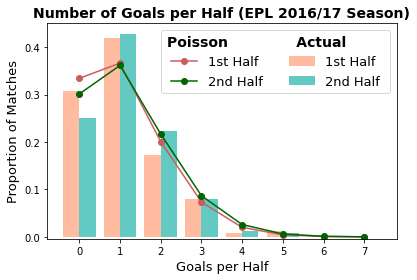

In [7]:
poisson_halves_pred = np.column_stack([[poisson.pmf(i, df_halves.mean()[j]) for i in range(8)] for j in range(2)])

plt.hist(df_halves.values, range(9), 
         alpha=0.7, label=['1st Half', '2nd Half'],density=True, stacked=False, color=["#FFA07A", "#20B2AA"])

pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,0],
                  linestyle='-', marker='o',label="1st Half", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,1],
                  linestyle='-', marker='o',label="2nd Half", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson              Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Half",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Half (EPL 2016/17 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.45])
plt.tight_layout()
plt.show()

In [8]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))


In [9]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([df[['Home','Away','FT_Goals_H']].assign(home=1).rename(
            columns={'Home':'team', 'Away':'opponent','FT_Goals_A':'goals'}),
           df[['Away','Home','FT_Goals_A']].assign(home=0).rename(
            columns={'Away':'team', 'Home':'opponent','FT_Goals_A':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()


In [10]:
game = simulate_match(poisson_model, 'Fluminense', 'Santos', max_goals=10)
print(game[0:4, 0:4])

[[0.16092382 0.12302873 0.04702868 0.01198472]
 [0.17095079 0.13069451 0.04995898 0.01273147]
 [0.09080127 0.06941897 0.02653593 0.00676238]
 [0.032153   0.02458146 0.00939645 0.00239458]]


In [11]:
from matplotlib.colors import ListedColormap

def matrix_gif(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5,5))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Goals', fontsize=12)
    ax1.set_ylabel('Home Team Goals', fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, subtitle, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, 'Fluminense', 'Santos', max_goals=5)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6, subtitle="Match Score Probability Matrix").savefig("match_matrix_0.png")
plt.close()
for t,(mat,colour,subtitle) in enumerate(zip([np.zeros((matn, matn)), np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn),
                                             np.array([0 if i+j<3 else 1 for i in range(matn) for j in range(matn)]).reshape(matn,matn)],
                          ['w', '#04f5ff', '#00ff85', '#e90052','#EAF205'],
                                   ['Match Score Probability Matrix', 'Home Win', 'Away Win', 'Draw', 'Over 2.5 goals'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6, subtitle=subtitle).savefig("match_matrix_{}.png".format(t+1))
    plt.close()